In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images, title = ''):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    plt.suptitle(title)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.3):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

from itertools import izip

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return izip(a, a)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST', one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


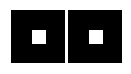

In [4]:
#Mask
mask = np.zeros(mnist.train.images[0].shape)
mask = center_square(mask,7,7)
rounded_mask = center_square(mask,7,7,1)
show = np.array([mask,rounded_mask])
show_array_images(show)

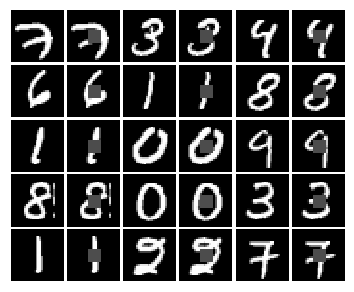

In [17]:
#Generating anomalies in images
masked_images = mask_images(mnist.train.images[0:15],'square',7,7, 0.3)
#masked_images = mask_images(mnist.train.next_batch(16),'square',10,10)
show_array_images(masked_images)

In [18]:
#Restore a model
tf.reset_default_graph()
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('../models/mnist_dcgan/mnist_dcgan.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../models/mnist_dcgan/'))

INFO:tensorflow:Restoring parameters from ../models/mnist_dcgan/mnist_dcgan.ckpt


In [19]:

#Search inside ops
graph = tf.get_default_graph()
ops = graph.get_operations()

#searching with name and shape!

for op in ops:
    if 'discriminator/dense_layer/Maximum' in op.name and not('gradients' in op.name):
        print(op.name, op.inputs, op.outputs) 
op = graph.get_operation_by_name("sub")
print(op.name, op.outputs)


(u'discriminator/dense_layer/Maximum', <tensorflow.python.framework.ops._InputList object at 0x7f1639c87850>, [<tf.Tensor 'discriminator/dense_layer/Maximum:0' shape=(?, 1024) dtype=float32>])
(u'sub', [<tf.Tensor 'sub:0' shape=(?, 784) dtype=float32>])


In [20]:
#Find the nodes in the graph
graph = tf.get_default_graph()

#input of first operation we want to restore: generator = genertor input
#gi = graph.get_tensor_by_name("random_uniform/mul:0")
gi = graph.get_tensor_by_name("random_normal/mul:0")

#output of last operation we want to restore: discriminator = generator output
go = graph.get_tensor_by_name("generator/last_op_generator:0")
#go = graph.get_tensor_by_name("generator/Reshape_1:0")

#Generator loss
gl = graph.get_tensor_by_name("generator_loss:0")
#gl = graph.get_tensor_by_name("Mean_2:0")

#Discriminator feature layer output
dfl = graph.get_tensor_by_name('discriminator/dense_layer/Maximum:0')

#Discriminator input
di = graph.get_tensor_by_name('sub:0')

In [21]:
def features(image):
    features = sess.run(dfl,feed_dict={di: np.reshape(image, [-1,784])})
    return features

In [22]:
np.linalg.norm(features(masked_images[0])-features(masked_images[1]))

0.44206378

In [23]:
np.linalg.norm(features(masked_images[0])-features(masked_images[3]))

0.72465461

In [24]:
def generator(z,gi,go):
    G_sample = sess.run(go, feed_dict={gi: z})
    return G_sample

In [25]:
# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
#input dimensions
image_shape = go.shape[1:].as_list()

#Variables 
z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=-0.5))

# Generated images
G_sample = generator(z,gi,go)

#Features of image
x = masked_images[0]
f = features(x)
features_shape = f.shape

#Get solver
z_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)

#Get loss
alpha = 0.8
beta = 100

with graph.as_default():
    images = tf.placeholder(tf.float32,image_shape, name='images') 
    xf = tf.placeholder(tf.float32,[1,1024], name='x_features') 
    #define loss
    L2_loss = tf.nn.l2_loss(go-images)
    perceptual_loss = tf.nn.l2_loss(dfl-xf)
    z_loss = alpha*L2_loss + (1-alpha)*beta*perceptual_loss
    z_grads = tf.gradients(z_loss, gi) 

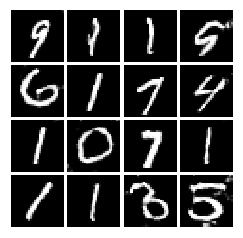

In [26]:
#Test sampling from generator
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = sess.run(tf.random_normal([batch_size, noise_dim], mean=0, stddev=1))
sample_out = sess.run(go, feed_dict={gi: z})
show_array_images(sample_out[0:16])

In [27]:
def z_search(z, x, real_x, features, alpha,beta, nIter = 3000, v = 0, momentum = 0.9, adam = False, nesterov = False,
             lr = 0.001, print_every = 250, show_every = 500, multiple_images = False, decay_every  = 1000, 
             m = 0):
    
    loss_history = []
    show_history = []
    
    for i in range(nIter):
        out_vars = [L2_loss, perceptual_loss, z_loss, z_grads, go]
        in_dict = {gi: z, images: preprocess_img(x), xf: features, di: generator(z,gi,go) }

        loss1, loss2, loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
        

        
        #step decay
        if (i % decay_every == 0):
            lr = 0.5*lr
            
        if nesterov:    
            #Nesterov
            v_prev = np.copy(v)
            v = momentum*v - lr*grad[0]
            z += (-momentum * v_prev +
                       (1 + momentum) * v)
            z = np.clip(z, -1, 1)
        
        if adam:
            eps = 1e-8
            beta1 = 0.9
            beta2 = 0.999
            # Adam t is your iteration counter going from 1 to infinity
            dx = grad[0]
            t = i+1
            m = beta1*m + (1-beta1)*dx
            mt = m / (1-beta1**t)
            v = beta2*v + (1-beta2)*(dx**2)
            vt = v / (1-beta2**t)
            z += - lr * mt / (np.sqrt(vt) + eps)
        
        
        
        #Mean image
        mean = np.mean(imout, axis = 0)
        mean = deprocess_img(mean)
        
        if not(multiple_images):
            if (i % print_every == 0):
                print('Iteration {}: {}, l2: {}, pl:{}'.format(i, loss, alpha*loss1, (1-alpha)*beta*loss2))
        
            

            if (i % show_every == 0):
                show = np.array([real_x,x,imout[0],mean])
                show_array_images(show)
                plt.show()
        else:
            if (i % show_every == 0):
                show_history.append(np.array([real_x,x,imout[0],mean]))
            
        loss_history.append(loss)
        
    if not(multiple_images):     
        #final print
        print('Final images:')
        show = np.array([real_x,x,imout[0],mean])
        show_array_images(show)
        plt.show()
    
    return imout, loss_history, mean

Iteration 0: 19722.2539062, l2: 17359.025, pl:2363.22769165


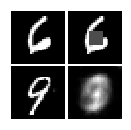

Iteration 200: 10833.4501953, l2: 6068.1171875, pl:4765.33294678


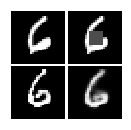

Iteration 400: 10864.2988281, l2: 5989.42109375, pl:4874.87670898


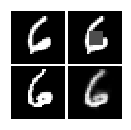

Iteration 600: 11239.4355469, l2: 5901.22421875, pl:5338.21166992


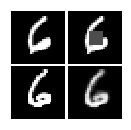

Iteration 800: 11093.6132812, l2: 5938.10820313, pl:5155.50537109


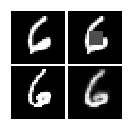

Iteration 1000: 10884.4667969, l2: 5906.00820313, pl:4978.4588623


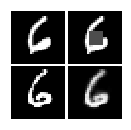

Iteration 1200: 7668.11621094, l2: 3669.94101563, pl:3998.17474365


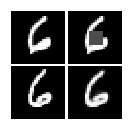

Iteration 1400: 7534.1015625, l2: 3590.09296875, pl:3944.00817871


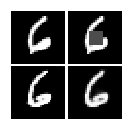

Iteration 1600: 7712.04541016, l2: 3681.1390625, pl:4030.90637207


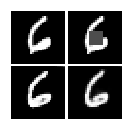

Iteration 1800: 7488.68408203, l2: 3571.01757812, pl:3917.66662598


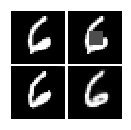

Final images:


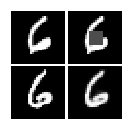

In [28]:
#Search in latent space
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = sess.run(tf.random_normal([batch_size, noise_dim], mean=0, stddev=1))

real_x = masked_images[6]
x = masked_images[7]
fts = features(x)

imout,loss_history, mean = z_search(z, x,real_x,fts, alpha, beta, nIter=2000, show_every=200, 
                                    print_every=200, lr = 1e-1, decay_every = 1000, adam = False, nesterov = True)

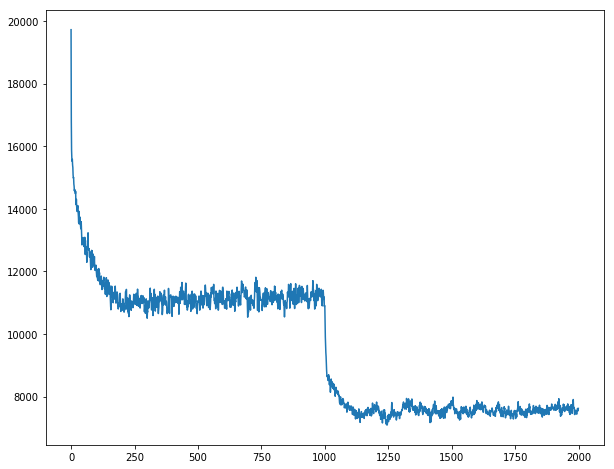

In [29]:
plt.plot(loss_history)
plt.show()

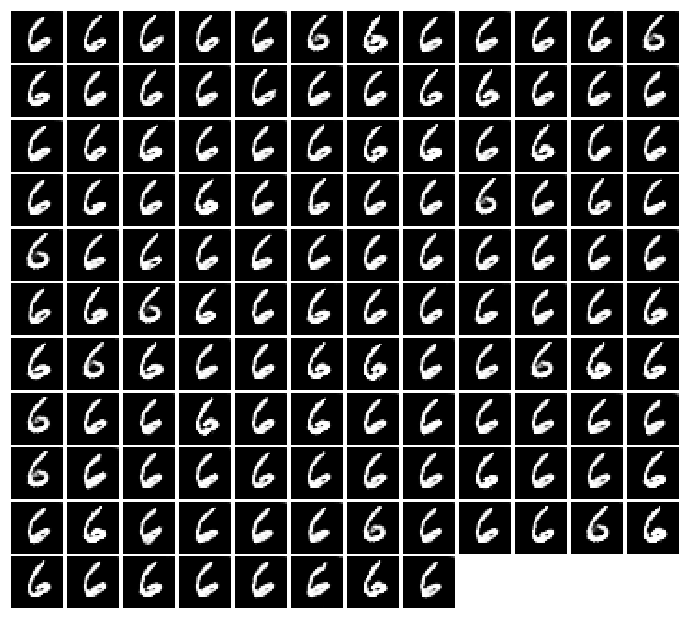

In [18]:
show_array_images(imout)

(0.0, 0.0, 0.98790741, 0.99607849)


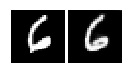

In [30]:
#mean image
mean = np.mean(imout, axis = 0)
mean = deprocess_img(mean)
print(np.min(mean), np.min(x), np.max(mean), np.max(x))

#round mean image
#mean2 = np.around(deprocess_img(mean))

show = np.array([real_x,mean])
show_array_images(show)

In [31]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

(0.0, 0.0, 0.99966824, 0.99607849)


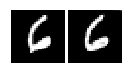

In [32]:
#Look for best image
losses = [mse(array_to_image(deprocess_img(img)),array_to_image(real_x)) for img in imout]
idx = np.argsort(losses)

best = imout[idx[0]]
best = deprocess_img(best)

#Sanity check
print(np.min(best), np.min(x), np.max(best), np.max(x))

show = np.array([real_x,best])
show_array_images(show)



L2: 44136.1796875, pl: 5.82341480255, loss: 35425.4140625


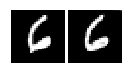

In [33]:
#Statistics of best image
img = best
beast = np.tile(img,(128,1))
fts = features(real_x)

out_vars = [L2_loss, perceptual_loss, z_loss]
in_dict = {go: beast, images: preprocess_img(x),xf: fts, di: beast}
loss1, loss2, loss = sess.run(out_vars, feed_dict=in_dict)
show = np.array([real_x,img])
show_array_images(show)
print('L2: {}, pl: {}, loss: {}'.format(loss1,loss2,loss))

L2: 44168.53125, pl: 14.1743144989, loss: 35618.3085938


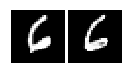

In [34]:
img = deprocess_img(imout[4])
beast = np.tile(img,(128,1))
fts = features(real_x)

out_vars = [L2_loss, perceptual_loss, z_loss]
in_dict = {go: beast, images: preprocess_img(x),xf: fts, di: beast}
loss1, loss2, loss = sess.run(out_vars, feed_dict=in_dict)
show = np.array([real_x,img])
show_array_images(show)
print('L2: {}, pl: {}, loss: {}'.format(loss1,loss2,loss))

In [24]:
#Compute perceptual losses for all images
perceptuals = []
for img in imout:
    img = deprocess_img(img)
    beast = np.tile(img,(128,1))
    fts = features(real_x)

    out_vars = [L2_loss, perceptual_loss, z_loss]
    in_dict = {go: beast, images: preprocess_img(x),xf: fts, di: beast}
    loss1, loss2, loss = sess.run(out_vars, feed_dict=in_dict) 
    perceptuals.append(loss2)

52.5382
49.5763
48.8414
42.2763
40.5086
40.0693
39.8452
36.4502
35.8902
35.3502
35.279
35.1378
35.1205
34.7476
34.5835


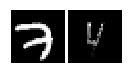

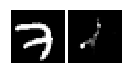

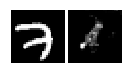

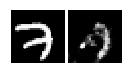

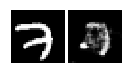

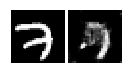

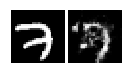

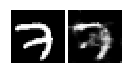

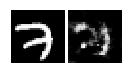

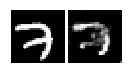

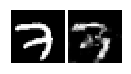

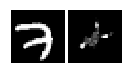

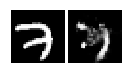

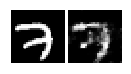

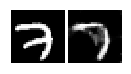

In [216]:
#Show best and worst perceptual images
idx = np.argsort(perceptuals)

for n in range(15):
    
    #best = imout[idx[n]]
    best = imout[idx[127-n]]
    #best = deprocess_img(best)

    print(perceptuals[idx[127-n]])

    show = np.array([real_x,best])
    show_array_images(show)

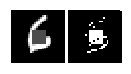

In [25]:
#Anomaly with best
threshold = 0.15
result = np.abs(best-x)
result[result >= threshold] = 1
result[result < threshold] = 0

show = np.array([x,result])
show_array_images(show)

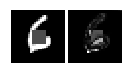

In [44]:
#Anomaly with mean
threshold = 0.15
result = np.abs(mean-x)
#result = np.clip(result,0,1)
#result[result >= threshold] = 1
#result[result < threshold] = 0

show = np.array([x,result])
show_array_images(show)

In [30]:
from sklearn.metrics import jaccard_similarity_score

ImportError: No module named sklearn.metrics

In [29]:
#MSE with mask
print(mse(array_to_image(rounded_mask),array_to_image(result)))
print(mse(array_to_image(rounded_mask),array_to_image(result)))

0.0497448979592
0.0497448979592


In [50]:
#Multiple z search
masked_images = mask_images(mnist.train.images[30:46],'square',7,7, 0.3)
input_images = masked_images[0:16]

#Final differences threshold for anomaly
threshold = 0.15

show = []
loss = []
anomaly_mse = []
counter = 1

for real_x, x in pairwise(input_images):
    z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
    fts = features(x)
    imout,loss_history, mean = z_search(z, x,real_x,fts, alpha, beta, nIter=2000, multiple_images=True, lr = 1e-1,
                                        decay_every = 1000, adam = False, nesterov = True) 
    loss.append(loss_history)

    #Anomaly with mean
    result = np.abs(mean-x)
    
    #Show only big differences
    result[result >= threshold] = 1
    result[result < threshold] = 0
    
    #Quantify error between detected anomaly and real anomaly
    m = mse(array_to_image(rounded_mask),array_to_image(result))
    anomaly_mse.append(m)   
    
    #Save show images
    s = np.array([real_x,x,rounded_mask,mean,imout[0],result])
    show.append(s)
    
    print('Pair: {}'.format(counter))
    counter += 1

Pair: 1
Pair: 2
Pair: 3
Pair: 4
Pair: 5
Pair: 6
Pair: 7
Pair: 8


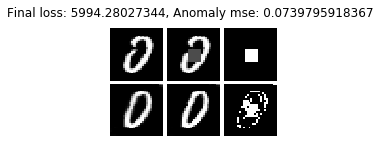

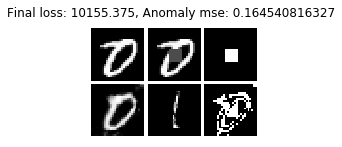

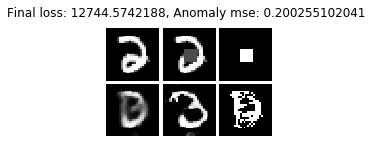

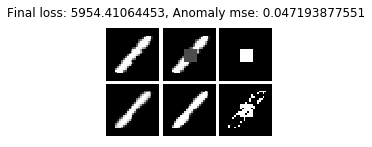

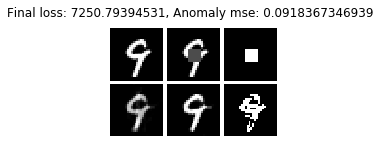

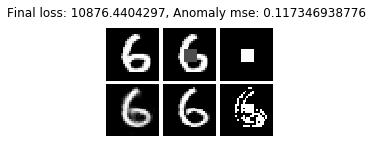

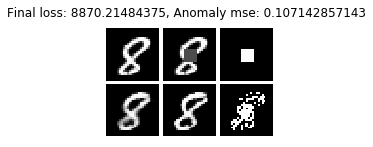

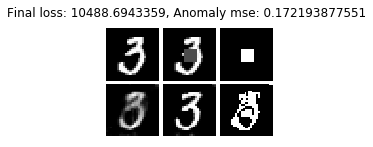

In [51]:
for i in range(len(loss)):
    title = 'Final loss: {}, Anomaly mse: {}'.format(loss[i][-1], anomaly_mse[i])
    show_array_images(show[i],title)

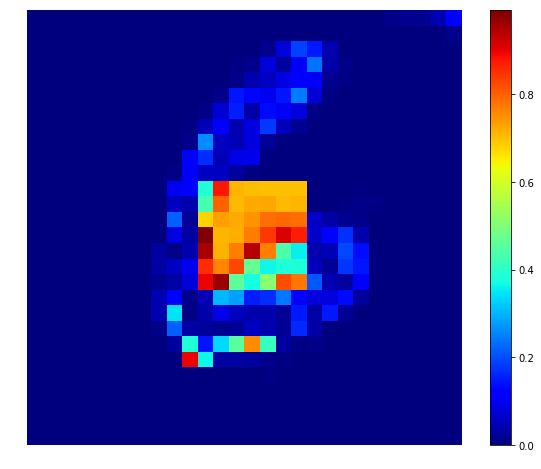

In [47]:
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#img1 = mpimg.imread('image1.png')
#img2 = mpimg.imread('image2.png')
img1 = array_to_image(rounded_mask)
img2 = array_to_image(result)

#img1 = np.stack((img1,)*3)
#img2 = np.stack((img2,)*3)

# Calculate the absolute difference on each channel separately
error_r = np.fabs(np.subtract(img2[:,:], img1[:,:]))
error_g = np.fabs(np.subtract(img2[:,:], img1[:,:]))
error_b = np.fabs(np.subtract(img2[:,:], img1[:,:]))

# Calculate the maximum error for each pixel
lum_img = np.maximum(np.maximum(error_r, error_g), error_b)

# Uncomment the next line to turn the colors upside-down
#lum_img = np.negative(lum_img);

imgplot = plt.imshow(lum_img)

# Choose a color palette
imgplot.set_cmap('jet')
#imgplot.set_cmap('Spectral') 

plt.colorbar()
plt.axis('off')

pylab.show()